<a href="https://colab.research.google.com/github/vbipin/aip/blob/master/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
#########
#This notebook has both decision tree and the Random forest classifier
#########

In [40]:
#Ref: https://www.cs.ubc.ca/~nando/540-2013/lectures.html
#lectures on Decision trees and Random forests
#http://www.cs.ubc.ca/~nando/540-2013/lectures/l8.pdf
#http://www.cs.ubc.ca/~nando/540-2013/lectures/l9.pdf

#Ref: Paper Criminisi et al, 2011
#https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/decisionForests_MSR_TR_2011_114.pdf

In [41]:
#In this we are exploring the decision tree algorithm
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [42]:
#Some util functions
from collections import Counter
def entropy( P ) :    
    #make sure that the incoming is a probability dist
    assert( abs(sum(P) - 1) < 0.0001 ) #sum(P) must be 1; sometimes because of float values it need not be exactly 1
    
    sum_all = 0
    for p in P :
        sum_all += -p * np.log2(p) #entropy is the sum of -p*log(p)
    
    return sum_all

def p_from_count( n_count ) :
    #print(n_count)
    N = sum(n_count)
    return [i/N for i in n_count]

def p_from_n_items( n_items ) :
    """count the items and build the probability distribution"""
    c = Counter(n_items)
    return p_from_count([c[i] for i in sorted(c.keys())])

def p_dict_from_n_items( n_items ) :
    """return a dict of {class: probability, ...}"""
    c = Counter(n_items)
    N = sum(c.values())
    p_dict = {label:count/N for label,count in c.items() }
    return p_dict

def entropy_from_n_items( n_items ) :
    """entropy form a list like [0,0,1,0,2,2]"""
    return entropy( p_from_n_items( n_items ) )


def data_split( X, Y, index_list ) :
    """Returns new X,Y at the indexs"""
    return X[index_list], Y[index_list] #worls only with numpy arrays



In [43]:
#some more utils for random forests

def argmax_of_p_dict( p_dict ) :
    """returns the key to the max value in the dict"""
    arg_max_value_and_key = sorted([ (v,k) for k,v in p_dict.items() ])[-1]
    return arg_max_value_and_key[1] #return just the key


def average_list_of_p_dict( list_of_dict ) :
    """make an average of lot of dicts"""
    new_dict = {}
    for d in list_of_dict :
        for k,v in d.items() :
            if k in new_dict :
                new_dict[k] += v
            else :
                new_dict[k] = v
    T = len(list_of_dict)
    return {k:v/T for k,v in new_dict.items()} #return the average

In [44]:
#we split a continuous variable according to a value in to left and right trees
#left branch is < 

def split_continuous_feature( X, feature_index, split_value ) :
    left_index = []
    right_index = []
    for i,x in enumerate(X) :
        if x[ feature_index ] < split_value :
            left_index.append(i) #we just store the index of the data points
        else :
            right_index.append(i)
    return left_index, right_index

In [45]:
#information gain

def information_gain( parent, child_list ) :
    """ parent is the list of y values
        child_list is the list of y values for each child node
    """
    parent_entropy = entropy_from_n_items(parent)
    #for expectation we need each child probability
    child_probability = [ len(c)/len(parent)      for c in child_list]
    child_entropy     = [ entropy_from_n_items(c) for c in child_list]
    children_expected_entropy = sum( [child_probability[i] * child_entropy[i] for i in range(len(child_list)) ] )
    
    return parent_entropy - children_expected_entropy

In [46]:
X = np.array([ 
    [1,1,3], 
    [2,1,5],
    [1,2,5],
    [3,1,7],
    [2,2.5,6],
    [3,3,2],
])
Y = np.array([1,1,1,1,0,0])

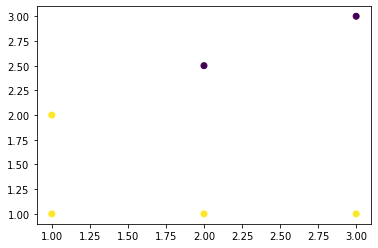

In [47]:
plt.scatter(X[:,0], X[:,1], c=Y)

In [48]:
l_index,r_index =split_continuous_feature(X, feature_index=1, split_value=2.2)
L = Y[l_index]
R = Y[r_index]
information_gain(Y,[L,R])

0.9182958340544896

In [49]:
########################################################################

In [50]:
def find_IG_of_all_splits(X, Y, feature_index) :
    """returns the IG of all the splits"""
    ig_list = []
    for split_value in X[:,feature_index] : #we split on all the values of this feature
        l_index,r_index =split_continuous_feature(X, feature_index, split_value)
        L = Y[l_index]
        R = Y[r_index]
        if len(L) and len(R) :
            ig_list.append( information_gain(Y,[L,R]) )
        else :
            if len(L) :
                ig_list.append( information_gain(Y,[L]) )
            else :
                ig_list.append( information_gain(Y,[R]) ) 
    return ig_list

In [51]:
def find_best_split(X,Y, feature_list=None ) :
    """Find the best split among the given features"""
    a = []
    if feature_list is None :
        feature_list = range(len(X[0])) #all the features
    for feature_index in feature_list :
        #for this feature, we find the information_gain for all the splits
        ig = find_IG_of_all_splits(X,Y,feature_index)
        max_ig = max(ig)
        max_ig_index = ig.index(max_ig) #find tha dta point with the best split.
        split_value = X[:,feature_index][max_ig_index]
        #store ig, feature and the value on which we did the split.
        a.append((max_ig,feature_index,split_value))

    return sorted(a) #this will be sorted on ig; so last one will be the best

In [52]:
#Tree node
class node :
    def __init__(self, feature_index, split_value, p_dict) :
        self.feature_index = feature_index
        self.split_value   = split_value
        self.p_dict        = p_dict # { class: probability }
        self.L = None  # < split_value
        self.R = None  # >= split_value

In [53]:
def build_decision_tree( PX, PY, depth, num_features=None) :
    if depth <= 0 :
        return None
    #for each node we create a sepeare list of features up to a max of num_features.
    #ref: slide 6 of CPSC 540 http://www.cs.ubc.ca/~nando/540-2013/lectures/l9.pdf
    if num_features is None : #we take all features
        feature_list = list(range(PX.shape[1]))
    else :
        feature_list = np.random.choice( range(PX.shape[1]), num_features, replace=False)
   
    _,f,v = find_best_split(PX,PY, feature_list)[-1] #last one is the best
    p = p_dict_from_n_items( PY )
    tree = node( f, v, p )
    
    if len(p.keys()) <= 1 :
        return tree #we dont need to split this node
        
    l_index,r_index =split_continuous_feature(PX, feature_index=f, split_value=v)
    if len(l_index) > 0 :
        LX, LY = data_split(PX,PY,l_index)
        tree.L = build_decision_tree( LX, LY, depth-1 )
    
    if len(r_index) > 0 :   
        RX, RY = data_split(PX,PY,r_index)
        tree.R = build_decision_tree( RX, RY, depth-1 )
    
    return tree

def apply_tree_node( node, x ) :
    prediction = argmax_of_p_dict(node.p_dict)
    if  len(node.p_dict.keys()) == 1 :
        return None, prediction, node.p_dict
    
    if x[node.feature_index] < node.split_value : #left tree
        return node.L, prediction, node.p_dict
    else :
        return node.R, prediction, node.p_dict

def tree_predict( node, x ) :
    """This will return the label of the data point x"""
    branch, prediction, p_dict = apply_tree_node(node,x)
    if branch is None : #if leaf node
        return prediction, p_dict
    #else, go down the tree
    return tree_predict(branch, x)

def predict( node, x ) :
    prediction, p_dict = tree_predict( node, x )
    return prediction

(150, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


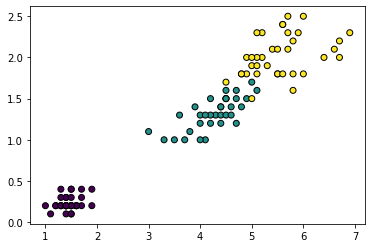

In [54]:
#############################################
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()

print(iris.data.shape)
print(iris.feature_names)
print(iris.target_names)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3) # 70% training and 30% test

#X = iris.data
#Y = iris.target

X=X_train
Y=y_train

plt.scatter(X[:, 2], X[:, 3],
               c=Y.astype(np.float), edgecolor='k')

In [55]:
#Work in progress. Just a backup

In [56]:
def accuracy( predicted, true ) :
    return list(predicted == true).count(True)/len(predicted)

In [57]:
tree = build_decision_tree( X, Y, 4)

In [58]:
y_ = [ predict(tree, X[i]) for i in range(len(X)) ]
accuracy(y_, y_train)

0.9714285714285714

In [59]:
t_ = [ predict(tree, X_test[i]) for i in range(len(X_test)) ]
accuracy(t_, y_test)

0.9333333333333333

In [60]:
#############################################################
#Another dataset

In [61]:
#ref: https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
from sklearn.datasets import load_breast_cancer
b = load_breast_cancer()

print(b.data.shape)
print(b.feature_names)
print(b.target_names)

(569, 30)
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']


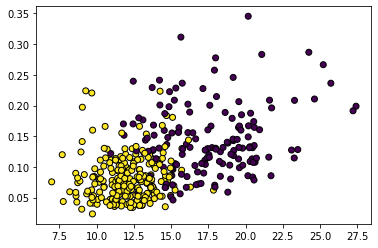

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(b.data, b.target, test_size=0.3) # 70% training and 30% test

#X = iris.data
#Y = iris.target

X=X_train
Y=y_train

plt.scatter(X[:, 0], X[:, 5],
               c=Y.astype(np.float), edgecolor='k')

In [63]:
tree = build_decision_tree( X, Y, depth=5)

y_ = [ predict(tree, X[i]) for i in range(len(X)) ]

accuracy(y_, y_train)

0.9824120603015075

In [64]:
t_ = [ predict(tree, X_test[i]) for i in range(len(X_test)) ]

accuracy(t_, y_test)

0.9590643274853801

In [65]:
#################################################################
# Random forests

In [90]:
def build_forest(X, Y, num_trees, num_features, max_depth) :
    forest = []
    for _ in range(num_trees) :
        
        #First we randomly choose a set of fetures for this tree
        #we slect the random features when we create each tree node.

        #For boosting we sample the dataset with replace=True
        row_list     = np.random.choice( range(X.shape[0]), size=X.shape[0], replace=True)
        #split the data according to the boosting
        new_x, new_y = data_split( X, Y, row_list ) #, feature_list)
        
        tree = build_decision_tree( new_x, new_y, max_depth, num_features)

        forest.append(tree)
        
    return forest

In [67]:
def forest_predict(forest, X_test) :
    """returns the predicted labels"""

    outcome = []
    for i in range(len(X_test)) :  
        #we collect the p_dicts from each tree for this data point      
        all_p_dicts = [ tree_predict(tree, X_test[i])[1] for tree in forest ]
        #take an average of the proability dist
        p_dict = average_list_of_p_dict( all_p_dicts )
        #Now, find the prediction from this new averaged p_dict
        t_ = argmax_of_p_dict( p_dict )
        outcome.append(t_)
    
    return np.array(outcome)


In [68]:
#util function to find the accuracy of the forest classifier        
def find_accuracy( forest, X_test, y_test ) : 
    t_ = forest_predict(forest, X_test)
    return accuracy(t_, y_test)

In [87]:
#We change the number of features and depth of each tree
#
#Let T be the number of trees 
num_trees = 10
num_features = 3 #we take only few features per tree
#boosting     = True
max_depth    = 3

In [91]:
forest = build_forest(X_train,y_train,num_trees, num_features, max_depth)

In [92]:
find_accuracy( forest, X_test, y_test)

0.9590643274853801

In [72]:
#############################################################################

In [73]:
####### RF from Sklearn ######################################################

In [85]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, max_features=3, random_state=0, criterion='entropy', n_estimators=10)

clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=2, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [86]:
t_ = clf.predict(X_test)
print( accuracy(t_, y_test) )

0.9707602339181286
